In [11]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler
import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import MultiStepLR,ReduceLROnPlateau,ExponentialLR
#torch.multiprocessing.set_start_method("spawn")
import resnet_angle
from skimage import transform as tf
from sklearn.model_selection import KFold
import os 

import numpy as np
import pandas as pd
from utils import progress_bar

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
BASE_dir = 'data/processed/'

train = pd.read_json(BASE_dir + 'train.json')
test = pd.read_json(BASE_dir + 'test.json')

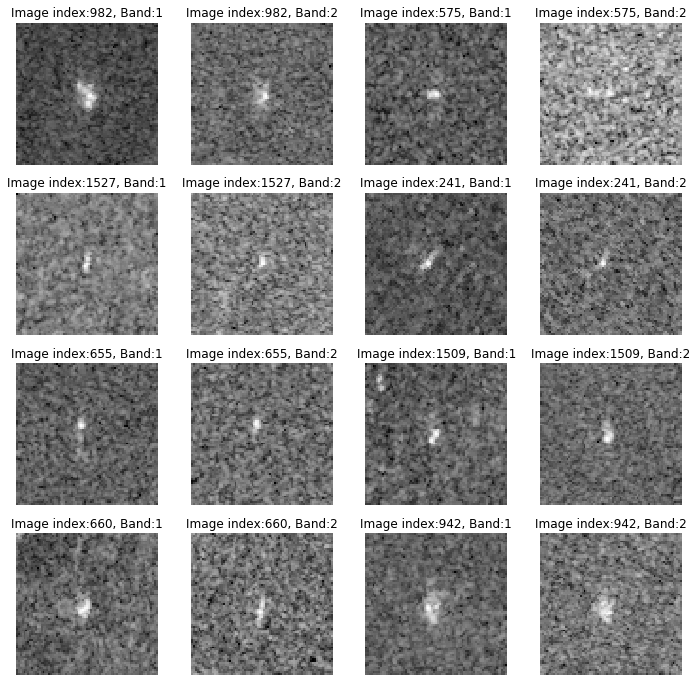

In [3]:
len(train) # 1604 obs
train.head(3)
#randomly draw some of them

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(4,4)

index = np.random.choice(list(range(len(train))),size=8, replace=False)
for num,i in enumerate(index):
    for j in range(2):
        ax = plt.subplot(gs[num*2+j])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Image index:%d, Band:%d' % (i, j%2+1))
        ax.set_aspect('equal')
        plt.imshow(np.array(train.iloc[i,j%2]).reshape(75,75))

In [18]:
#prepare data
use_cuda= True if torch.cuda.is_available() else False
#use_cuda =False
#dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor 
dtype = torch.FloatTensor 
data=  pd.read_json(BASE_dir + 'train.json')

class iceberg_dataset(Dataset):
    def __init__(self, data, label, transform=None): #data: 1604 * 3 *75* 75
        self.data =data
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label=  self.data[idx], self.label[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=1).copy()
            if np.random.uniform()>0.5:
                img = np.flip(img,axis=2).copy()
            rotate = np.random.randint(4, size=1)
            if rotate:
                img = np.rot90(img,k=rotate,axes=(1,2)).copy()
            img = torch.from_numpy(img).type(dtype)
            img = self.transform(img)

        return img, label

    
class iceberg_angle_dataset(Dataset):
    def __init__(self, data,angle, label, transform=None, test=False): #data: 1604 * 3 *75* 75
        self.data =data
        self.angle=torch.from_numpy(angle).type(torch.FloatTensor)
        self.label = torch.from_numpy(label).type(torch.LongTensor)
        self.transform= transform
        self.test= test
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img, label, angle=  self.data[idx], self.label[idx], self.angle[idx]
        if self.transform is not None:
            #Random Horizontal Flip and Vertical Flip 
            #https://discuss.pytorch.org/t/torch-from-numpy-not-support-negative-strides/3663
            
            #rotate, scale, shear, translation
#             if self.test is False:
#                 angle = np.random.uniform(0,360)
#                 img = tf.rotate(img,angle=angle,resize=False)
#                 scale1 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 scale2 = np.exp(np.random.uniform(np.log(1/1.2), np.log(1.2)))
#                 #shear = np.random.uniform(-np.pi/18, np.pi/18)
#                 #tran = np.random.uniform(-5, 5)
#                 #aug = tf.AffineTransform(shear = shear, translation=tran, scale= (scale1, scale2))
#                 aug = tf.AffineTransform(scale= (scale1, scale2))
#                 img = tf.warp(img, inverse_map=aug)
            
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
            
            if self.test is False:
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=1).copy()
#                 if np.random.uniform()>0.5:
#                     img = np.flip(img,axis=2).copy()
#                 rotate = np.random.randint(4, size=1)
#                 if rotate:
#                     img = np.rot90(img,k=rotate,axes=(1,2)).copy()
                pass
        img = torch.from_numpy(img).type(dtype)
        img = self.transform(img)

        return img, angle,label
    
def data_aug(X, angle, y):    
    X_rot_30 = []
    X_rot_60 = [] 
    X_h = np.flip(X, 3)
    X_v = np.flip(X, 2)
    for i in X:
        X_rot_30.append(tf.rotate(i,angle=90,resize=False))
        X_rot_60.append(tf.rotate(i,angle=270,resize=False))
        
    X_rot_30 = np.stack(X_rot_30)
    X_rot_60 = np.stack(X_rot_60)
    ch_angle = np.concatenate((angle,angle,angle,angle,angle))
    ch_y = np.concatenate((y,y,y,y,y))
    ch_X = np.concatenate((X, X_h, X_v, X_rot_30, X_rot_60))
    return ch_X, ch_angle, ch_y
    
    
def stack(row):
    return np.stack(row[['c1','c2','c3']]).reshape(3,75,75)

def raw_to_numpy(data):
    img = []
    data['c1'] = data['band_1'].apply(np.array)
    data['c2'] = data['band_2'].apply(np.array)
    data['c3'] = (data['c1'] + data['c2'])/2
#     data['c3'] = (data['c1'] + data['c2'])/2
    for _, row in data.iterrows():
        img.append(stack(row))
    return np.stack(img)

def transform_compute(img):
    train_mean = img.mean(axis=(0,2,3))
    train_std = img.std(axis=(0,2,3))
    return train_mean, train_std

train_X = raw_to_numpy(data)#.transpose(0,2,3,1)
train_X.shape     #1604 * 3 *75* 75   N*c*H*W
train_y = data['is_iceberg'].values # if iceberg then 1

In [5]:
train_X_del = train_X#[data.inc_angle!='na',:,:,:]
train_y_del = train_y#[data.inc_angle!='na']
result = []
for num,i in enumerate(train_X_del):
    temp = []
    for j in i:
        temp.append(tf.rescale(j,224/75,mode='constant'))
    img = np.stack(temp)
    result.append(img)
    if num%50==0:
        print('We are %d'%num)
train_X_del = np.stack(result)

We are 0
We are 50
We are 100
We are 150
We are 200
We are 250
We are 300
We are 350
We are 400
We are 450
We are 500
We are 550
We are 600
We are 650
We are 700
We are 750
We are 800
We are 850
We are 900
We are 950
We are 1000
We are 1050
We are 1100
We are 1150
We are 1200
We are 1250
We are 1300
We are 1350
We are 1400
We are 1450
We are 1500
We are 1550
We are 1600


In [4]:
# train_index=list(range(1300))
# val_index= list(range(1300,1604))
# # train_index=list(range(304,1604)) 
# # val_index= list(range(304))
# train_X[train_index].shape

# train_mean, train_std = transform_compute(train_X[train_index])
# train_transform = T.Compose([
#     T.Normalize(train_mean, train_std)
# ])

# train_dataset = iceberg_dataset(data= train_X[train_index], label=train_y[train_index], transform=train_transform)
# val_dataset = iceberg_dataset(data= train_X[val_index], label=train_y[val_index], transform=train_transform)

# train_loader = DataLoader(train_dataset, batch_size = 16, num_workers=3, 
#                           shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)

train_index=list(range(1604))
train_mean, train_std = transform_compute(train_X[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])


In [14]:
#data.inc_angle[data.inc_angle=='na']=0
data.inc_angle

0       43.9239
1       38.1562
2       45.2859
3       43.8306
4       35.6256
5       36.9034
6       34.4751
7       41.1769
8       35.7829
9       43.3007
10       44.624
11      39.5067
12      41.8544
13      45.2909
14      34.7715
15       43.782
16      45.3568
17      38.7812
18      42.5145
19      37.2802
20      41.7973
21      38.0669
22      39.6636
23      37.6866
24       40.296
25       39.234
26      40.3904
27      43.7895
28      42.5891
29      41.0303
         ...   
1574          0
1575          0
1576          0
1577          0
1578          0
1579          0
1580          0
1581          0
1582          0
1583          0
1584          0
1585          0
1586          0
1587          0
1588          0
1589          0
1590          0
1591          0
1592          0
1593          0
1594          0
1595          0
1596          0
1597          0
1598          0
1599          0
1600          0
1601          0
1602          0
1603          0
Name: inc_angle, Length:

In [13]:
train_X_del = train_X
data.inc_angle[data.inc_angle=='na']=0
train_angle_del = data['inc_angle'].values
train_angle_del = train_angle_del.astype(np.float)/90
train_y_del = train_y#[data.inc_angle!='na']
# # train_X_del = train_X
# # train_y_del = train_y

# seed= np.random.RandomState(123)
# spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
# train_index, val_index = next(spliter.split(train_X_del))

train_index=list(range(304,1604)) 
val_index= list(range(304))

# # train_index=list(range(284,1471)) 
# # val_index= list(range(284))

train_mean, train_std = transform_compute(train_X_del[train_index])
train_transform = T.Compose([
    T.Normalize(train_mean, train_std)
])
#af_train_X,af_train_angle, af_train_y = data_aug(train_X_del[train_index], train_angle_del[train_index],train_y_del[train_index])
#af_train_X, af_train_y = data_aug2(train_X_del[train_index], train_y_del[train_index])
af_train_X, af_train_angle ,af_train_y = data_aug(train_X_del[train_index],train_angle_del[train_index], train_y_del[train_index])

train_dataset = iceberg_angle_dataset(data= af_train_X,angle=af_train_angle, label=af_train_y, transform=train_transform)
val_dataset = iceberg_angle_dataset(data= train_X_del[val_index], angle=train_angle_del[val_index],label=train_y_del[val_index], transform=train_transform, test=True)

train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
torch.cuda.is_available()
torch.from_numpy(train_X).type(torch.FloatTensor)[1].shape
train_X[1]
use_cuda

True

In [16]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
#         scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x,batch_angle, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_angle = batch_angle.unsqueeze(1)
            batch_angle=batch_angle.type(torch.FloatTensor)
            if use_cuda:
                batch_x,batch_angle, batch_y = batch_x.cuda(),batch_angle.cuda(),batch_y.cuda()
            x = Variable(batch_x)
            angle = Variable(batch_angle)
            y = Variable(batch_y)
            out = net((x, angle))
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'resnet34_ang_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'resnet34_ang_loss.pth')
            if loss_avg/total >val_loss:
                e_s=0

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss,best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x,val_angle, val_y) in enumerate(val_load):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total

In [ ]:
result={}

drop1_list = [0.3,0.4,0.5,0.6,0.7]
drop2_list = [0.4,0.5,0.8,0.6,0.7]
for i in range(20):
    drop1 = drop1_list[np.random.randint(5,size=1)[0]]
    drop2 = drop2_list[np.random.randint(5,size=1)[0]]
    wd = np.exp(np.random.uniform(np.log(0.0001),np.log(0.05),size=1)[0])
    
    msg = 'Round {}, drop1: {}, drop2:{}, wd: {}'.format(i,drop1,drop2,wd)
    print(msg)
    resnet50_net = resnet_angle.resnet50(pretrained=True)
    net= resnet50_net
    net.fc = nn.Sequential(
        nn.Linear(512 * 4+1,256 * 4),
        nn.BatchNorm1d(256 * 4),
        nn.ReLU(True),
        nn.Dropout(drop1),
        nn.Linear(256 * 4,256 * 4),
        nn.BatchNorm1d(256 * 4),
        nn.ReLU(True),
        nn.Dropout(drop2),
        nn.Linear(256 * 4,2)
    )

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=wd, nesterov= True)
    #optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.0001)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    scheduler = ExponentialLR(optimizer,gamma=0.92)
    #scheduler = ReduceLROnPlateau(optimizer, 'max', patience =15,min_lr= 0.00001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   
    a= train(epoch=50,early_stopping= 20)
    result[msg]=a
    print(a)

In [19]:



drop1 = 0.5
drop2 = 0.5
#wd = np.exp(np.random.uniform(np.log(0.0001),np.log(0.05),size=1)[0])
for i in range(1):
    resnet34_net = resnet_angle.resnet34(pretrained=False)
    net= resnet34_net
    expansion=1
    net.fc = nn.Sequential(
    #     nn.Linear(512 * expansion+1,256 * expansion),
    #     nn.BatchNorm1d(256 * expansion),
    #     nn.ReLU(True),
    #     nn.Dropout(drop1),
    #         nn.Linear(256 * expansion,256 * expansion),
    #         nn.BatchNorm1d(256 * expansion),
    #         nn.ReLU(True),
    #         nn.Dropout(drop2),
    #     nn.Linear(256 * expansion,2)
        nn.Linear(512 * expansion+1,2)
    )

    criterion = nn.CrossEntropyLoss()

    #Adam does not perform so good here   
    #(0.1, 0.0001) (50, 80, 110, 170) 52 epoch reaches the maximum.
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
    #optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay=0.002)
    #scheduler = MultiStepLR(optimizer, [100, 150,200], gamma=0.1)
    # scheduler = ExponentialLR(optimizer,gamma=0.95)
    scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.00001)
    #5e-3 86
    if use_cuda:
        criterion.cuda()
        net.cuda()
    #     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
    #     cudnn.benchmark = True   
    a= train(epoch=200,early_stopping= 20)
    print(a)


This is epoch:1
[========= 204/204 ======>]Step: 0ms| Tot: 16s6ms|Loss: 0.726 | Acc: 58.954% (3832/6500)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.685 | Acc: 50.000% (152/304)
acc: Save it!

This is epoch:2
[========= 204/204 ======>]Step: 0ms| Tot: 16s6ms|Loss: 0.558 | Acc: 68.954% (4482/6500)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 6.528 | Acc: 50.000% (152/304)
loss: Save it!

This is epoch:3
[========= 204/204 ======>]Step: 0ms| Tot: 16s6ms|Loss: 0.609 | Acc: 68.769% (4470/6500)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.437 | Acc: 78.618% (239/304)
acc: Save it!

This is epoch:4
[========= 204/204 ======>]Step: 0ms| Tot: 16s6ms|Loss: 0.482 | Acc: 75.246% (4891/6500)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 3.618 | Acc: 50.000% (152/304)
loss: Save it!

This is epoch:5
[========= 204/204 ======>]Step: 0ms| Tot: 16s6ms|Loss: 0.486 | Acc: 75.969% (4938/6500)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.328 | Acc: 86.184% (2

Process Process-235:
Process Process-236:
Process Process-237:
Traceback (most recent call last):
Traceback (most recent call last):
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/mult

KeyboardInterrupt: 

In [16]:
# for i in result:
#     if result[i][0]<0.25:
#         print(i)
#         print(result[i])
print(a)

(0.1807175176708322, 93.09210526315789, 56)


In [ ]:
##For continue training
resnet50 = resnet.resnet50(num_classes=2)
net= resnet50
net.load_state_dict(torch.load('resnet50_acc.pth'))

criterion = nn.CrossEntropyLoss()

#Adam does not perform so good here
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.002, nesterov= True)
scheduler = MultiStepLR(optimizer, [50,100], gamma=0.1)
#5e-3 86
if use_cuda:
    criterion.cuda()
    net.cuda()
#     resnet101 = torch.nn.DataParallel(resnet101, device_ids=range(torch.cuda.device_count()))
#     cudnn.benchmark = True   

train(epoch=150)

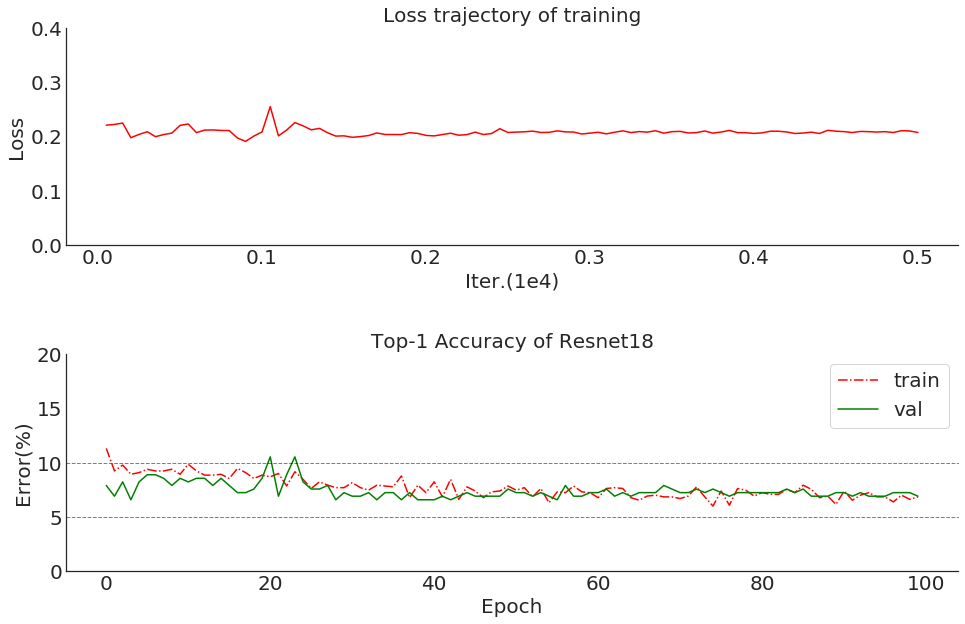

In [15]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

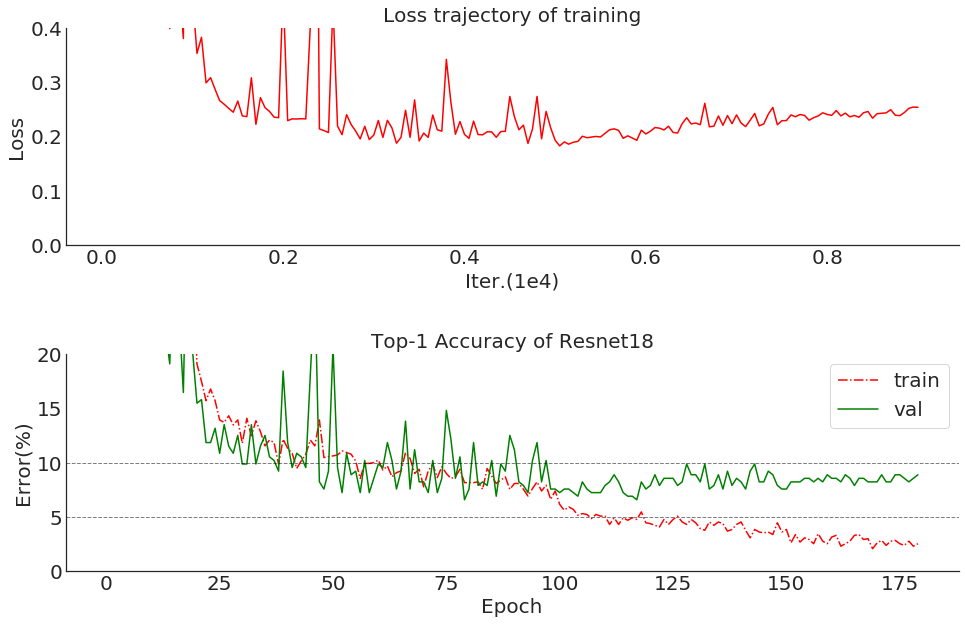

In [28]:
plt.style.use('seaborn-white')
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0.5)
fig = plt.figure(figsize=(16,10))
fig1 = fig.add_subplot(gs[0,0])
fig2 = fig.add_subplot(gs[1,0])
fig1.spines['right'].set_visible(False)
fig1.spines['top'].set_visible(False)
# for item in [fig1.xaxis.label, fig1.yaxis.label,fig2.xaxis.label, fig2.yaxis.label]:
#     item.set_fontsize(10)


# fig1.plot([i * 0.005 for i in range(1,len(train_data['loss_hist'])+1)],train_data['loss_hist'],color='black')
fig1.plot([i * 0.005 for i in range(1,len(train_data['val_loss_hist'])+1)],train_data['val_loss_hist'],color='red')
fig1.set(title= 'Loss trajectory of training',ylabel='Loss',xlabel='Iter.(1e4)',ylim=(0,0.4))

fig2.plot([100-i for i in train_data['train_acc_hist']], color='red',linestyle='-.',label = 'train')
fig2.plot([100-i for i in train_data['val_acc_hist']], color='green',linestyle='-',label='val')
fig2.legend(frameon=True)
fig2.spines['right'].set_visible(False)
fig2.spines['top'].set_visible(False)
fig2.axhline(y=[5],alpha=0.5, linestyle='--',color='k',linewidth=1)
fig2.axhline(y=[10],alpha=0.5, linestyle='--',color='k',linewidth=1)
_=fig2.set(title= 'Top-1 Accuracy of Resnet18',ylim=(0,20),xlabel='Epoch',ylabel='Error(%)')

In [23]:
def train(epoch,early_stopping = None):
    global train_data#,out,y,predicted
    acc=0
    best_acc =0
    best_val_loss= 100
    loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    train_data={}
    train_data['loss_hist'] = loss_hist
    train_data['val_loss_hist'] = val_loss_hist
    train_data['train_acc_hist'] = train_acc_hist
    train_data['val_acc_hist'] =  val_acc_hist
    e_s= 0
    last_lr = optimizer.param_groups[0]['lr']
    
    for i in range(epoch):
        print('\nThis is epoch:{}'.format(i+1))
        total= 0
        correct=0
        loss_avg= 0
#         scheduler.step()
        scheduler.step(acc)
        if optimizer.param_groups[0]['lr'] < last_lr:
            print('lr change from %f to %f\n' %(last_lr,optimizer.param_groups[0]['lr']))
            last_lr = optimizer.param_groups[0]['lr']
        net.train()
        for j,(batch_x,batch_angle, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()
            batch_angle = batch_angle.unsqueeze(1)
            batch_angle=batch_angle.type(torch.FloatTensor)
            if use_cuda:
                batch_x,batch_angle, batch_y = batch_x.cuda(),batch_angle.cuda(),batch_y.cuda()
            x = Variable(batch_x)
            angle = Variable(batch_angle)
            y = Variable(batch_y)
            out = net((x, angle))
            loss = criterion(out, y)
            loss_avg += loss.cpu().data[0] *out.size()[0]
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
            if j % 5==0:
                loss_hist.append(loss_avg/total)
            
        train_acc_hist.append(100.*correct/total)
        e_s+=1
        if i %1 == 0:
            acc, val_loss = test(val_loader)
            val_acc_hist.append(acc)
            if acc >best_acc:
                best_acc= acc
                e_s = 0
                print('acc: Save it!')
                torch.save(net.state_dict(), 'res34_ang_acc.pth')
            if val_loss <best_val_loss and loss_avg/total <=val_loss :
                best_val_loss= val_loss
                e_s = 0
                print('loss: Save it!')
                torch.save(net.state_dict(), 'res34_ang_loss.pth')
            if loss_avg/total >val_loss:
                e_s=0

#             if best_val_loss >= val_loss:
#                 best_val_loss= val_loss
#                 torch.save(net.state_dict(), 'resnet34_loss%d.pth'%i)
        if early_stopping is not None and e_s >= early_stopping:
            return best_val_loss,best_acc,i

    return best_val_loss,best_acc,i
#         if i%50==0 and save:
#             torch.save(net.state_dict(), 'resnet50.pth')
        
def test(val_load):
    net.eval()
    total = 0
    correct = 0
    loss_avg= 0
    for k, (val_x,val_angle, val_y) in enumerate(val_load):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        loss = criterion(out, y)
        loss_avg += loss.cpu().data[0] *out.size()[0]
        #print(out.size())
        _, predicted = torch.max(out.data, 1)
        correct += predicted.eq(y.data).cpu().sum()
        total += out.size()[0]
        progress_bar(k, len(val_load), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss_avg/total, 100.*correct/total, correct, total))
    train_data['val_loss_hist'].append(loss_avg/total) #also keep track of loss of val set
    acc =  (correct*100.0)/total
    return acc,loss_avg/total


for rou in range(1):
    ran_num = 9220
    seed= np.random.RandomState(ran_num)
    spliter = KFold(n_splits=5,shuffle =True,random_state = seed)
    for k,(train_index, val_index) in enumerate(spliter.split(train_X_del)):
        
        train_mean, train_std = transform_compute(train_X_del[train_index])
        train_transform = T.Compose([
            T.Normalize(train_mean, train_std)
        ])
        #af_train_X,af_train_angle, af_train_y = data_aug(train_X_del[train_index], train_angle_del[train_index],train_y_del[train_index])
        #af_train_X, af_train_y = data_aug2(train_X_del[train_index], train_y_del[train_index])
        af_train_X, af_train_angle ,af_train_y = train_X_del[train_index],train_angle_del[train_index], train_y_del[train_index]

        train_dataset = iceberg_angle_dataset(data= af_train_X,angle=af_train_angle, label=af_train_y, transform=train_transform)
        val_dataset = iceberg_angle_dataset(data= train_X_del[val_index], angle=train_angle_del[val_index],label=train_y_del[val_index], transform=train_transform, test=True)

        train_loader = DataLoader(train_dataset, batch_size = 32, num_workers=3, 
                                  shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size = 64, num_workers=3)
        
        candidate = []
        for rep in range(3):
            resnet34_net = resnet_angle.resnet34(pretrained=False)
            net= resnet34_net
            expansion=1
            net.fc = nn.Sequential(
                nn.Linear(512 * expansion+1,2)
            )

            criterion = nn.CrossEntropyLoss()
            optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0002, nesterov= True)
            scheduler = ReduceLROnPlateau(optimizer, 'max', patience =10,min_lr= 0.00001)
                    #5e-3 86
            if use_cuda:
                criterion.cuda()
                net.cuda()

            result = train(epoch=250,early_stopping= 20)
            candidate.append(result[0])
            with open("resnet34_models/log.txt", "a") as myfile:
                msg = 'Phase1, At fold {}, seed {},round {} we find one with acc: {}, loss: {}\n'.format(
                                                            k,ran_num,rep+1, result[1], result[0])
                myfile.write(msg)
            cmd = 'cp res34_ang_loss.pth res34_ang_loss{}.pth'.format(rep)
            os.system(cmd)

        #actually an array
        #also change here

        for g in range(3):
            cmd = 'cp res34_ang_loss{}.pth resnet34_models/r1_res34_ang{}_{}{}.pth'.format(g,rou,k,g)
            os.system(cmd)



This is epoch:1
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.614 | Acc: 65.082% (835/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.737 | Acc: 52.336% (168/321)
acc: Save it!
loss: Save it!

This is epoch:2
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.533 | Acc: 74.903% (961/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.911 | Acc: 53.583% (172/321)
acc: Save it!

This is epoch:3
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.490 | Acc: 76.617% (983/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 27.412 | Acc: 47.664% (153/321)

This is epoch:4
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.899 | Acc: 72.720% (933/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.467 | Acc: 76.324% (245/321)
acc: Save it!

This is epoch:5
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.437 | Acc: 80.826% (1037/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.402 | Acc: 83.489% (268/321)
a

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.257 | Acc: 88.932% (1141/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 5.357 | Acc: 47.975% (154/321)

This is epoch:16
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.504 | Acc: 81.606% (1047/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.298 | Acc: 85.981% (276/321)

This is epoch:17
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.284 | Acc: 87.841% (1127/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.831 | Acc: 77.259% (248/321)

This is epoch:18
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.287 | Acc: 87.217% (1119/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.272 | Acc: 89.097% (286/321)

This is epoch:19
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.296 | Acc: 87.607% (1124/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.736 | Acc: 57.009% (183/321)

This is epoch:20
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|L

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.403 | Acc: 82.931% (1064/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.398 | Acc: 82.555% (265/321)
acc: Save it!

This is epoch:10
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.314 | Acc: 85.814% (1101/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.330 | Acc: 85.047% (273/321)
acc: Save it!
loss: Save it!

This is epoch:11
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.288 | Acc: 87.841% (1127/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.261 | Acc: 87.850% (282/321)
acc: Save it!

This is epoch:12
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.283 | Acc: 88.309% (1133/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 4.065 | Acc: 47.664% (153/321)

This is epoch:13
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.484 | Acc: 83.398% (1070/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.435 | Acc: 67.601% (217/321)

This is ep

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.866 | Acc: 67.601% (217/321)

This is epoch:22
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.258 | Acc: 89.867% (1153/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.586 | Acc: 73.209% (235/321)

This is epoch:23
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.241 | Acc: 90.023% (1155/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.480 | Acc: 79.439% (255/321)

This is epoch:24
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.212 | Acc: 91.193% (1170/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.372 | Acc: 83.489% (268/321)

This is epoch:25
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.279 | Acc: 87.607% (1124/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.492 | Acc: 80.997% (260/321)

This is epoch:26
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.242 | Acc: 90.803% (1165/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Los

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 2.185 | Acc: 53.894% (173/321)

This is epoch:15
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.373 | Acc: 85.425% (1096/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 3.486 | Acc: 46.417% (149/321)

This is epoch:16
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.417 | Acc: 85.892% (1102/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.267 | Acc: 88.474% (284/321)

This is epoch:17
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.288 | Acc: 88.387% (1134/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.236 | Acc: 89.408% (287/321)
acc: Save it!

This is epoch:18
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.258 | Acc: 88.387% (1134/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.221 | Acc: 89.408% (287/321)

This is epoch:19
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.280 | Acc: 87.997% (1129/1283)
[=========   6/  6 ==>....]Step: 0ms

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.429 | Acc: 79.735% (1023/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.453 | Acc: 78.816% (253/321)
acc: Save it!
loss: Save it!

This is epoch:4
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.438 | Acc: 80.670% (1035/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.437 | Acc: 76.947% (247/321)

This is epoch:5
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.405 | Acc: 82.775% (1062/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.295 | Acc: 85.670% (275/321)
acc: Save it!

This is epoch:6
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.370 | Acc: 84.801% (1088/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.597 | Acc: 74.143% (238/321)

This is epoch:7
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.306 | Acc: 87.607% (1124/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.419 | Acc: 83.801% (269/321)
loss: Save it!

This is epoch

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.296 | Acc: 87.529% (1123/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.769 | Acc: 77.882% (250/321)

This is epoch:18
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.362 | Acc: 82.619% (1060/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.297 | Acc: 90.031% (289/321)

This is epoch:19
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.319 | Acc: 86.048% (1104/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.421 | Acc: 83.178% (267/321)

This is epoch:20
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.310 | Acc: 86.750% (1113/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.337 | Acc: 85.358% (274/321)

This is epoch:21
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.276 | Acc: 87.607% (1124/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.573 | Acc: 78.505% (252/321)

This is epoch:22
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|L

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.297 | Acc: 87.217% (1119/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.707 | Acc: 74.766% (240/321)

This is epoch:17
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.364 | Acc: 83.788% (1075/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.329 | Acc: 88.162% (283/321)
acc: Save it!

This is epoch:18
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.275 | Acc: 87.841% (1127/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.527 | Acc: 77.882% (250/321)

This is epoch:19
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.284 | Acc: 87.295% (1120/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.484 | Acc: 80.062% (257/321)

This is epoch:20
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.262 | Acc: 88.309% (1133/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.338 | Acc: 85.981% (276/321)
loss: Save it!

This is epoch:21
[=========  41/ 41 ==

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.206 | Acc: 91.193% (1170/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.310 | Acc: 87.850% (282/321)

This is epoch:32
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.215 | Acc: 90.959% (1167/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.259 | Acc: 90.031% (289/321)

This is epoch:33
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.219 | Acc: 91.037% (1168/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.287 | Acc: 90.654% (291/321)

This is epoch:34
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.178 | Acc: 92.829% (1191/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.328 | Acc: 87.227% (280/321)

This is epoch:35
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.209 | Acc: 91.115% (1169/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.339 | Acc: 87.227% (280/321)

This is epoch:36
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|L

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.305 | Acc: 87.227% (280/321)
acc: Save it!

This is epoch:16
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.278 | Acc: 88.153% (1131/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.371 | Acc: 82.866% (266/321)

This is epoch:17
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.329 | Acc: 86.048% (1104/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.924 | Acc: 57.632% (185/321)

This is epoch:18
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.316 | Acc: 87.607% (1124/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.288 | Acc: 85.981% (276/321)

This is epoch:19
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.283 | Acc: 87.529% (1123/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.181 | Acc: 52.960% (170/321)

This is epoch:20
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.313 | Acc: 86.204% (1106/1283)
[=========   6/  6 ==>....]Step: 0ms

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.214 | Acc: 90.881% (1166/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.264 | Acc: 89.097% (286/321)

This is epoch:38
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.220 | Acc: 91.504% (1174/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.259 | Acc: 89.720% (288/321)

This is epoch:39
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.200 | Acc: 92.128% (1182/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.253 | Acc: 89.408% (287/321)
loss: Save it!

This is epoch:40
lr change from 0.001000 to 0.000100

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.194 | Acc: 92.751% (1190/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.265 | Acc: 90.654% (291/321)
acc: Save it!

This is epoch:41
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.214 | Acc: 91.582% (1175/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.257 | Acc: 90.654% (291/321)

T

[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.268 | Acc: 87.539% (281/321)
loss: Save it!

This is epoch:35
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.208 | Acc: 91.816% (1178/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.281 | Acc: 89.097% (286/321)

This is epoch:36
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.211 | Acc: 91.115% (1169/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.406 | Acc: 85.670% (275/321)

This is epoch:37
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.251 | Acc: 88.776% (1139/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.440 | Acc: 82.866% (266/321)

This is epoch:38
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.215 | Acc: 91.037% (1168/1283)
[=========   6/  6 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.253 | Acc: 86.916% (279/321)
loss: Save it!

This is epoch:39
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.178 | Acc: 92.907% (1192/1283)
[=========   6/  6 =

[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 1.615 | Acc: 61.875% (198/320)

This is epoch:45
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.309 | Acc: 88.318% (1134/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.327 | Acc: 85.000% (272/320)

This is epoch:46
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.214 | Acc: 91.121% (1170/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.262 | Acc: 88.438% (283/320)

This is epoch:47
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.198 | Acc: 91.822% (1179/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.271 | Acc: 87.188% (279/320)

This is epoch:48
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.201 | Acc: 91.044% (1169/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 2.799 | Acc: 59.062% (189/320)

This is epoch:49
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.267 | Acc: 89.642% (1151/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Los

[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.264 | Acc: 90.312% (289/320)

This is epoch:67
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.151 | Acc: 95.093% (1221/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.263 | Acc: 90.312% (289/320)

This is epoch:68
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.157 | Acc: 92.991% (1194/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.263 | Acc: 90.312% (289/320)

This is epoch:69
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.150 | Acc: 93.692% (1203/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.263 | Acc: 90.000% (288/320)

This is epoch:70
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.153 | Acc: 93.692% (1203/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.264 | Acc: 90.000% (288/320)

This is epoch:71
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.149 | Acc: 93.847% (1205/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Los

[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.178 | Acc: 93.069% (1195/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.240 | Acc: 89.375% (286/320)

This is epoch:74
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.176 | Acc: 93.224% (1197/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.242 | Acc: 89.375% (286/320)

This is epoch:75
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.186 | Acc: 91.667% (1177/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.243 | Acc: 88.438% (283/320)

This is epoch:76
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.162 | Acc: 93.458% (1200/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.244 | Acc: 88.750% (284/320)

This is epoch:77
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|Loss: 0.182 | Acc: 92.679% (1190/1284)
[=========   5/  5 ==>....]Step: 0ms| Tot: 1ms|Loss: 0.242 | Acc: 89.688% (287/320)

This is epoch:78
[=========  41/ 41 ======>]Step: 0ms| Tot: 3s2ms|L

In [20]:
#30,60, 90 learning rate decay
#
resnetOB.res

{'all': {'params': [{'lr': 0.099969837126105854, 'wd': 0.0048768157841404631},
   {'lr': 0.005636454096473553, 'wd': 0.0012221947368002359},
   {'lr': 0.099246510214096528, 'wd': 0.0027344024076647543},
   {'lr': 0.099959725736288932, 'wd': 0.0024664062526430623},
   {'lr': 0.099422206390654952, 'wd': 0.0071210893402104142},
   {'lr': 0.0026487236284499088, 'wd': 0.0015270389790467936},
   {'lr': 0.0082483652834426258, 'wd': 0.0012592003869237804},
   {'lr': 0.0048465324038598672, 'wd': 0.0012104365001951837},
   {'lr': 0.0064880244084614732, 'wd': 0.0012612161415386236},
   {'lr': 0.0090556414439709517, 'wd': 0.0010343458814944075}],
  'values': [90.78947368421052,
   91.44736842105263,
   89.80263157894737,
   90.131578947368425,
   89.473684210526315,
   91.118421052631575,
   90.78947368421052,
   90.78947368421052,
   88.486842105263165,
   90.78947368421052]},
 'max': {'max_params': {'lr': 0.005636454096473553,
   'wd': 0.0012221947368002359},
  'max_val': 91.44736842105263}}

In [18]:
out1 = torch.cat((out.data,out.data),1)
out1.size()
# out
criterion(out,y.long())
type(predicted)
type(y.data)
#predicted.eq(y.data).cpu().sum()

torch.cuda.DoubleTensor

In [8]:
temp11=pd.DataFrame()
test = pd.read_json(BASE_dir + 'test.json')
test_X = raw_to_numpy(test)
test_X.shape 
fake_label = np.zeros(len(test_X))


test_dataset = iceberg_angle_dataset(data= test_X, angle=test['inc_angle'].values/90,label=fake_label, transform=train_transform)

test_loader = DataLoader(test_dataset, batch_size = 64, num_workers=3)

waiting_list = [
    'r1_res34_ang0_01.pth',
    'r1_res34_ang0_12.pth',
    'r1_res34_ang0_22.pth',
    'r1_res34_ang0_31.pth',
    'r1_res34_ang0_42.pth'
]

waiting_list = [os.path.join('resnet34_models',i) for i in waiting_list]

for num,i in enumerate(waiting_list):
    net = resnet_angle.resnet34(num_classes=2)
    expansion=1
    net.fc = nn.Sequential(
                nn.Linear(512 * expansion+1,2)
            )

    net.load_state_dict(torch.load(i))
    net.cuda()
    prob = [] 
    net.eval()

    for k, (val_x,val_angle, val_y) in enumerate(test_loader):
        val_angle = val_angle.unsqueeze(1)
        val_angle=val_angle.type(torch.FloatTensor)
        if use_cuda:
            val_x, val_angle,val_y = val_x.cuda(),val_angle.cuda(), val_y.cuda()
        x = Variable(val_x)
        angle=Variable(val_angle)
        y = Variable(val_y)
        out = net((x,angle))
        temp = np.exp(out.cpu().data.numpy()-np.max(out.cpu().data.numpy(),axis=1)[:,np.newaxis])
        ans= temp[:,1]/(temp.sum(axis=1))
        prob.append(ans)
        progress_bar(k, len(test_loader))
    msg='iceberg%d'% num
    temp11[msg] = np.concatenate(prob)
        

[========= 132/132 ======>]Step: 0ms| Tot: 5s8ms
[========= 132/132 ======>]Step: 0ms| Tot: 5s8ms
[========= 132/132 ======>]Step: 0ms| Tot: 5s8ms
[========= 132/132 ======>]Step: 0ms| Tot: 5s9ms
[========= 132/132 ======>]Step: 0ms| Tot: 5s8ms


In [39]:
np.concatenate(prob).shape

(8424,)

In [10]:
sub=pd.DataFrame()
sub['id'] = test['id']
sub['is_iceberg'] =temp11.mean(axis=1)# np.concatenate(prob)
sub.shape
sub.to_csv('submissioncc.csv',index=False)

In [9]:
# temp= pd.read_csv('submission3.csv') #0.0001 wd one
# sub['is_iceberg2'] = temp['is_iceberg']
#np.sum(test['inc_angle'].values)
temp11.corr()

,iceberg0,iceberg1,iceberg2,iceberg3,iceberg4
iceberg0,1.000000,0.908735,0.871255,0.857815,0.923203
iceberg1,0.908735,1.000000,0.887282,0.896424,0.937904
iceberg2,0.871255,0.887282,1.000000,0.796136,0.881015
iceberg3,0.857815,0.896424,0.796136,1.000000,0.899083
iceberg4,0.923203,0.937904,0.881015,0.899083,1.000000
